In [1]:
import DirectDmTargets as dddm

calculating effective efficancy for Xe detector done
calculating effective efficancy for Ar detector done
calculating effective efficancy for Ge detector done
todo


In [2]:
import time

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tqdm import tqdm

# Finding the correct 'factor' #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

25 october 2019 

## Goal ## 
- in the DetectorSpectrum-class a factor is used to rebin the DM-spectrum. This rebinning should be fine enough to allow the numerical integration to be sufficiently accurate. However we don't want a too fine binning as it does increase computation time drastically. 

## Result ##
A factor (the factor between the the bins used for the numerical integration and the spectrum) is set to **10** as this proved a fair trade off between speed and accuracy.

## Distribution of the DM ##
First we need to make a DM-rate spectrum (below we first compare the un-smeared and smeared spectrum)

In [8]:
use_SHM = dddm.SHM()

In [9]:
# No detector resolution
def plot_spectrum(data, color = 'blue', label = 'label', linestyle = 'none'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']),
                color = color,
                linestyle = linestyle,
                capsize = 2,
                marker = 'o',
                label = label
                )

In [10]:
%%time
xe_events = dddm.GenSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
xe_events.n_bins = 10
xe_galact = xe_events.get_data(poisson = False)
xe_galact

Wall time: 13 ms


,counts,bin_centers,bin_left,bin_right
0,449.967261,5.0,0.0,10.0
1,172.541377,15.0,10.0,20.0
2,61.551390,25.0,20.0,30.0
3,20.377729,35.0,30.0,40.0
4,6.183480,45.0,40.0,50.0
5,1.675711,55.0,50.0,60.0
6,0.384984,65.0,60.0,70.0
7,0.066505,75.0,70.0,80.0
8,0.005831,85.0,80.0,90.0
9,0.000015,95.0,90.0,100.0


In [11]:
def get_det_spec(det):
    events = dddm.DetectorSpectrum(50, 1e-45, use_SHM, dddm.detectors[det])
    return events.get_data(poisson = False)

In [12]:
%%time
get_det_spec('Xe')

Wall time: 476 ms


,counts,bin_centers,bin_left,bin_right
0,20.543476,5.0,0.0,10.0
1,156.624879,15.0,10.0,20.0
2,64.765430,25.0,20.0,30.0
3,22.123232,35.0,30.0,40.0
4,6.992244,45.0,40.0,50.0
5,2.005902,55.0,50.0,60.0
6,0.504013,65.0,60.0,70.0
7,0.103457,75.0,70.0,80.0
8,0.014957,85.0,80.0,90.0
9,0.001162,95.0,90.0,100.0


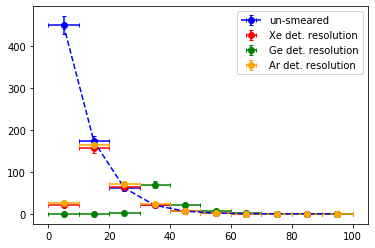

In [13]:
plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
plot_spectrum(get_det_spec('Xe'), 'red', label = 'Xe det. resolution')
plot_spectrum(get_det_spec('Ge'), 'green', label = 'Ge det. resolution')
plot_spectrum(get_det_spec('Ar'), 'orange', label = 'Ar det. resolution')
plt.legend()

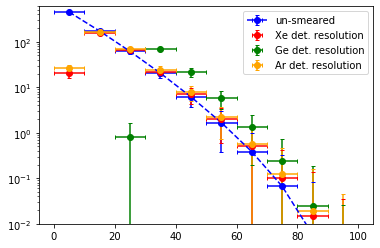

In [14]:
plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
plot_spectrum(get_det_spec('Xe'), 'red', label = 'Xe det. resolution')
plot_spectrum(get_det_spec('Ge'), 'green', label = 'Ge det. resolution')
plot_spectrum(get_det_spec('Ar'), 'orange', label = 'Ar det. resolution')
plt.yscale("log")
plt.ylim(0.01,600)
plt.legend()

## Finding the correct factor ##

In [15]:
factors = np.array([4,8,10,25,50,100,1000,10000])
results = {}
for factor in tqdm(factors):
    start = time.time()
    xe_ev = dddm.DetectorSpectrum(50, 1e-45, use_SHM, dddm.detectors['Xe'])
    xe_ev.rebin_factor = factor
    xe_res = xe_ev.get_data(poisson = False)
    end = time.time()
    
    results[factor] = {'time':end-start, "data":xe_res}
    

100%|█████████████████████████████████████████████████████████████████████████████████| 8/8 [03:36<00:00, 27.09s/it]


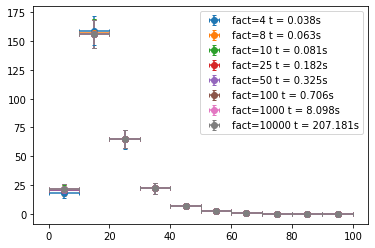

In [16]:
def plot_results(data, label = 'label'):
    plt.errorbar(data['bin_centers'], data['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
                yerr = np.sqrt(data['counts']),
                linestyle = 'none',
                capsize = 2,
                marker = 'o',
                label = label
                )
for res in results.keys():
    plot_results(results[res]['data'], f"fact={res} t = %.3fs"%results[res]['time'])
plt.legend()

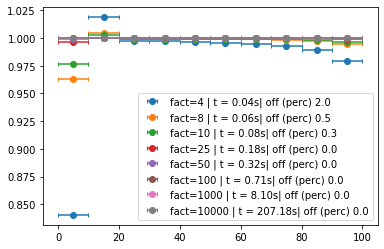

In [17]:
def plot_results_compare(data, data2, label = 'label'):
    off_percent = 100 - 100 * np.mean(np.abs(data['counts']/data2['counts']))
    plt.errorbar(data['bin_centers'], data['counts']/data2['counts'], 
                xerr=(data['bin_left'] - data['bin_right'])/2,
#                 yerr = np.sqrt(data['counts'])/data2['counts'],
                linestyle = 'none',
                capsize = 2,
                marker = 'o',
                label = label + "| off (perc) %.1f"%off_percent
                )
    
for res in results.keys():
    plot_results_compare(results[res]['data'], 
                         results[np.max(factors)]['data'], 
                         f"fact={res} | t = %.2fs"%results[res]['time'])
plt.legend()

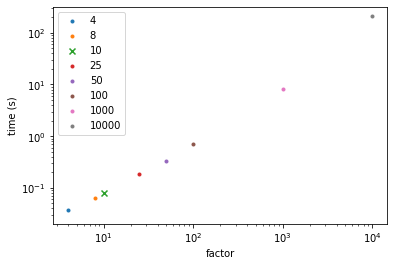

In [18]:
for x in results.keys():
    plt.scatter(x, results[x]['time'], label = x, 
                marker = "x" if x == 10 else ".")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("time (s)")
plt.xlabel("factor")
plt.legend()